# Tricky detail when converting a random forest from scikit-learn into ONNX

*scikit-learn* use a specific comparison when computing the preduction of a decision tree, it does ``(float)x <= threshold`` (see [tree.pyx / method apply_dense](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pyx#L796)). *ONNX* does not specify such things and compares *x* to _threshold_, both having the same type. What to do then when writing the converter.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Conversion to float

In [3]:
import numpy
N = 1000
delta = 1e-9
factor = 10
dxs = numpy.empty((2 * N,), dtype=numpy.float64)
fxs = numpy.empty((2 * N,), dtype=numpy.float32)
for i, x in enumerate(range(-N, N)):
    dx = (1. + x * delta) * factor
    dxs[i] = dx
    fxs[i] = dx

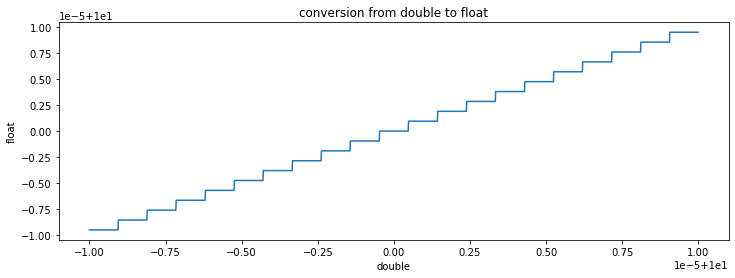

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(dxs, fxs)
ax.set_title("conversion from double to float")
ax.set_xlabel("double")
ax.set_ylabel("float");

## Region where (float)x <= y

Let's see how the comparison ``(float)x <= y`` looks like.

In [5]:
N = 100
delta = 36e-10
xs = []
ys = []
for x in range(-N, N):
    for y in range(-N, N):
        dx = (1. + x * delta) * factor
        dy = (1. + y * delta) * factor
        if numpy.float32(dx) <= numpy.float64(dy):
            xs.append(dx)
            ys.append(dy)            

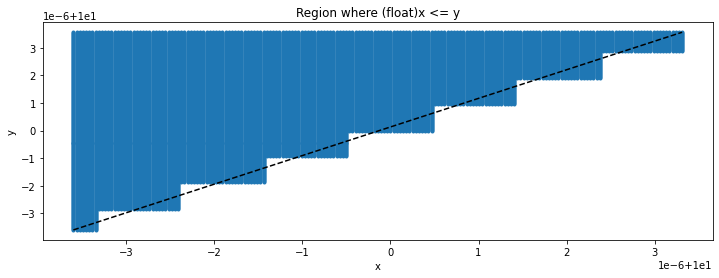

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(xs, ys, ".")
ax.set_title("Region where (float)x <= y")
ax.plot([min(xs), max(xs)], [min(ys), max(ys)], 'k--')
ax.set_xlabel("x")
ax.set_ylabel("y");

## Equivalent to (float)x <= (float)y ?

In [7]:
def area_mismatch_rule(N, delta, factor, rule=None):
    if rule is None:
        rule = lambda t: numpy.float32(t)
    xst = []
    yst = []
    xsf = []
    ysf = []
    for x in range(-N, N):
        for y in range(-N, N):
            dx = (1. + x * delta) * factor
            dy = (1. + y * delta) * factor
            c1 = 1 if numpy.float32(dx) <= numpy.float64(dy) else 0
            c2 = 1 if numpy.float32(dx) <= rule(dy) else 0
            key = abs(c1 - c2)
            if key == 1:
                xsf.append(dx)
                ysf.append(dy)     
            else:
                xst.append(dx)
                yst.append(dy)
    return xst, yst, xsf, ysf

xst1, yst1, xsf1, ysf1 = area_mismatch_rule(100, delta, 1.)
"factor=%1.1f, error area %1.4f%s" % (1., len(xsf1) * 1.0 / (len(xst1) + len(xsf1)) * 100, "%")

'factor=1.0, error area 5.7525%'

Applied to a decision tree, it does not mean that the evaluation of the condition of each node would fail in 5.75% of the cases, it depends on how the thresholds are built and the area of errors depends on the numbers.

In [8]:
factor = 10
xst, yst, xsf, ysf = area_mismatch_rule(100, delta, factor)
"factor=%1.1f, error area %1.4f%s" % (factor, len(xsf) * 1.0 / (len(xst) + len(xsf)) * 100, "%")

'factor=10.0, error area 6.2025%'

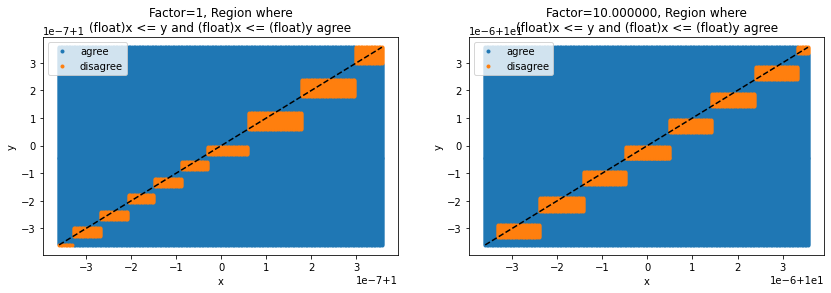

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(xst1, yst1, '.', label="agree")
ax[0].plot(xsf1, ysf1, '.', label="disagree")
ax[0].set_title("Factor=1, Region where\n(float)x <= y and (float)x <= (float)y agree")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].plot([min(xst1), max(xst1)], [min(yst1), max(yst1)], 'k--')
ax[0].legend()
ax[1].plot(xst, yst, '.', label="agree")
ax[1].plot(xsf, ysf, '.', label="disagree")
ax[1].set_title("Factor=%f, Region where\n(float)x <= y and (float)x <= (float)y agree" % factor)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].plot([min(xst), max(xst)], [min(yst), max(yst)], 'k--')
ax[1].legend();

## Good threshold

In [10]:
def good_threshold(dy):
    fy = numpy.float32(dy)
    if fy == dy:
        return fy
    if fy < dy:
        return fy
    eps = max(abs(fy), numpy.finfo(numpy.float32).eps) * 10
    nfy = numpy.nextafter([fy], [fy - eps], dtype=numpy.float32)[0]    
    return nfy

good_threshold(1.), good_threshold(1 + 1e-8), good_threshold(1 - 1e-8)

(1.0, 1.0, 0.99999994)

In [11]:
xst1, yst1, xsf1, ysf1 = area_mismatch_rule(100, delta, 1., good_threshold)
"factor=%1.1f, error area %1.4f%s" % (1., len(xsf1) * 1.0 / (len(xst1) + len(xsf1)) * 100, "%")

'factor=1.0, error area 0.0000%'

In [12]:
xst, yst, xsf, ysf = area_mismatch_rule(100, delta, 1e20, good_threshold)
"factor=%1.1g, error area %1.4f%s" % (1e20, len(xsf) * 1.0 / (len(xst) + len(xsf)) * 100, "%")

'factor=1e+20, error area 0.0000%'

In [13]:
factor = 10
xst, yst, xsf, ysf = area_mismatch_rule(100, delta, factor, good_threshold)
"factor=%1.1f, error area %1.4f%s" % (factor, len(xsf) * 1.0 / (len(xst) + len(xsf)) * 100, "%")

'factor=10.0, error area 0.0000%'

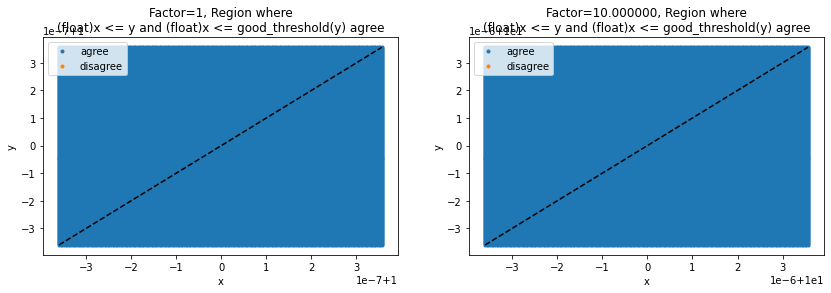

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(xst1, yst1, '.', label="agree")
ax[0].plot(xsf1, ysf1, '.', label="disagree")
ax[0].set_title("Factor=1, Region where\n(float)x <= y and (float)x <= good_threshold(y) agree")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].plot([min(xst1), max(xst1)], [min(yst1), max(yst1)], 'k--')
ax[0].legend()
ax[1].plot(xst, yst, '.', label="agree")
ax[1].plot(xsf, ysf, '.', label="disagree")
ax[1].set_title("Factor=%f, Region where\n(float)x <= y and (float)x <= good_threshold(y) agree" % factor)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].plot([min(xst), max(xst)], [min(yst), max(yst)], 'k--')
ax[1].legend();

Let's draw the function:

In [15]:
N = 1000
dxs2 = numpy.empty((2 * N,), dtype=numpy.float64)
fxs1 = numpy.empty((2 * N,), dtype=numpy.float32)
fxs2 = numpy.empty((2 * N,), dtype=numpy.float32)
for i, x in enumerate(range(-N, N)):
    dx = 1. + x * 1e-9
    dxs2[i] = dx
    fxs1[i] = numpy.float32(dx)
    fxs2[i] = good_threshold(dx)

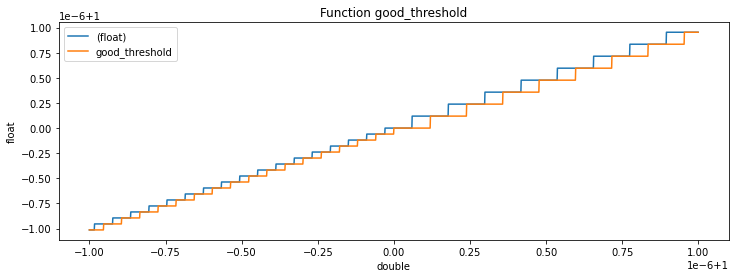

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(dxs2, fxs1, label="(float)")
ax.plot(dxs2, fxs2, label="good_threshold")
ax.set_title("Function good_threshold")
ax.set_xlabel("double")
ax.set_ylabel("float")
ax.legend();

That's explain some tricky lines in package [skl2onnx](https://github.com/onnx/sklearn-onnx/tree/master/skl2onnx). Let's check if it still works with negative value.

In [17]:
N = 100
xst = []
yst = []
xsf = []
ysf = []
for x in range(-N, N):
    for y in range(-N, N):
        dx = -1. + x * delta
        dy = -1. + y * delta
        c1 = 1 if numpy.float32(dx) <= numpy.float64(dy) else 0
        c2 = 1 if numpy.float32(dx) <= good_threshold(dy) else 0
        key = abs(c1 - c2)
        if key == 1:
            xsf.append(dx)
            ysf.append(dy)     
        else:
            xst.append(dx)
            yst.append(dy)

"error area %1.4f%s" % (len(xsf) * 1.0 / (len(xst) + len(xsf)) * 100, "%")

'error area 0.0000%'

It works.

## What about double double?

In [18]:
def area_mismatch_rule_double(N, delta, factor, rule=None):
    if rule is None:
        rule = lambda t: numpy.float64(t)
    xst = []
    yst = []
    xsf = []
    ysf = []
    for x in range(-N, N):
        for y in range(-N, N):
            dx = (1. + x * delta) * factor
            dy = (1. + y * delta) * factor
            c1 = 1 if numpy.float32(dx) <= numpy.float64(dy) else 0
            c2 = 1 if numpy.float64(dx) <= rule(dy) else 0
            key = abs(c1 - c2)
            if key == 1:
                xsf.append(dx)
                ysf.append(dy)     
            else:
                xst.append(dx)
                yst.append(dy)
    return xst, yst, xsf, ysf
            
xst1, yst1, xsf1, ysf1 = area_mismatch_rule_double(100, delta, 1.)
"factor=%1.1f, error area %1.4f%s" % (1., len(xsf1) * 1.0 / (len(xst1) + len(xsf1)) * 100, "%")

'factor=1.0, error area 3.1125%'

In [19]:
xst, yst, xsf, ysf = area_mismatch_rule_double(100, delta, 1e20)
"factor=%1.1g, error area %1.4f%s" % (1e20, len(xsf) * 1.0 / (len(xst) + len(xsf)) * 100, "%")

'factor=1e+20, error area 2.9900%'

In [20]:
xst, yst, xsf, ysf = area_mismatch_rule_double(100, delta, factor)
"factor=%1.1f, error area %1.4f%s" % (factor, len(xsf) * 1.0 / (len(xst) + len(xsf)) * 100, "%")

'factor=10.0, error area 3.1975%'

The probability it fails is lower than for floats but still significant.

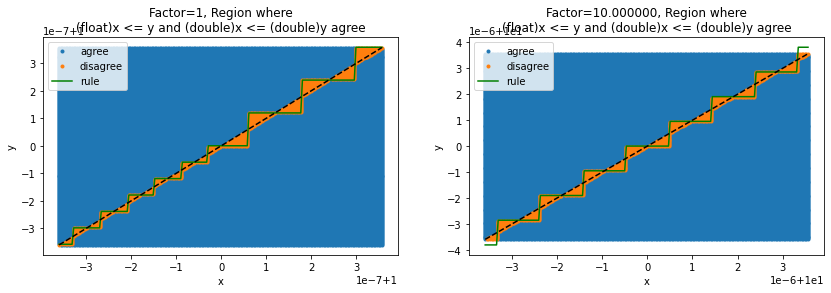

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(xst1, yst1, '.', label="agree")
ax[0].plot(xsf1, ysf1, '.', label="disagree")
xs = list(sorted(set(xst1)))
ys = [numpy.float32(x) for x in xs]
ax[0].plot(xs, ys, 'g', label='rule')
ax[0].set_title("Factor=1, Region where\n(float)x <= y and (double)x <= (double)y agree")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].plot([min(xst1), max(xst1)], [min(yst1), max(yst1)], 'k--')
ax[0].legend()
ax[1].plot(xst, yst, '.', label="agree")
ax[1].plot(xsf, ysf, '.', label="disagree")
xs = list(sorted(set(xst)))
ys = [numpy.float32(x) for x in xs]
ax[1].plot(xs, ys, 'g', label='rule')
ax[1].set_title("Factor=%f, Region where\n(float)x <= y and (double)x <= (double)y agree" % factor)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].plot([min(xst), max(xst)], [min(yst), max(yst)], 'k--')
ax[1].legend();

Let's fix it in a similar way. Let's first define a function which finds the split double which defines the border between doubles, below the are rounded to one float, above it, they are rounded to another float. And it is not always to middle of it.

In [22]:
def find_switch_point(fy, nfy):
    "Finds the double so that ``(float)x != (float)(x + espilon)``."
    a = numpy.float64(fy)
    b = numpy.float64(nfy)
    fa = numpy.float32(a)
    fb = numpy.float32(b)
    a0, b0 = a, a
    while a != a0 or b != b0:
        a0, b0 = a, b
        m = (a + b) / 2
        fm = numpy.float32(m)
        if fm == fa:
            a = m
            fa = fm
        else:
            b = m
            fb = fm
    return a

find_switch_point(1, 1.0000000876)

1.0000000596046448

In [23]:
def good_threshold_double(dy):
    fy = numpy.float32(dy)
    eps = max(abs(fy), numpy.finfo(numpy.float32).eps) * 10
    afy = numpy.nextafter([fy], [fy - eps], dtype=numpy.float32)[0]    
    afy2 = find_switch_point(afy, fy)
    if fy > dy > afy2:
        return afy2        
    bfy = numpy.nextafter([fy], [fy + eps], dtype=numpy.float32)[0]
    bfy2 = find_switch_point(fy, bfy)
    if fy <= dy <= bfy2:
        return bfy2        
    return fy

good_threshold_double(1.0), numpy.float32(1.0000000216)

(1.0000000596046448, 1.0)

In [24]:
xst1, yst1, xsf1, ysf1 = area_mismatch_rule_double(100, delta, 1., good_threshold_double)
"factor=%1.1f, error area %1.4f%s" % (1., len(xsf1) * 1.0 / (len(xst1) + len(xsf1)) * 100, "%")

'factor=1.0, error area 0.0000%'

In [25]:
xst, yst, xsf, ysf = area_mismatch_rule_double(100, delta, 1e20, good_threshold_double)
"factor=%1.1g, error area %1.4f%s" % (1e20, len(xsf) * 1.0 / (len(xst) + len(xsf)) * 100, "%")

'factor=1e+20, error area 0.0000%'

In [26]:
xst, yst, xsf, ysf = area_mismatch_rule_double(100, delta, factor, good_threshold_double)
"factor=%1.1f, error area %1.4f%s" % (factor, len(xsf) * 1.0 / (len(xst) + len(xsf)) * 100, "%")

'factor=10.0, error area 0.0000%'

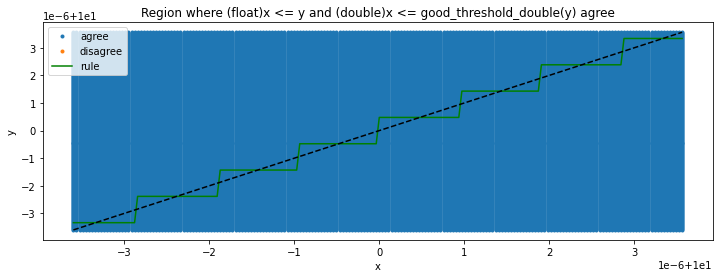

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(xst, yst, '.', label="agree")
ax.plot(xsf, ysf, '.', label="disagree")
xs = list(sorted(set(xst)))
ys = [good_threshold_double(x) for x in xs]
ax.plot(xs, ys, 'g', label='rule')
ax.set_title("Region where (float)x <= y and (double)x <= good_threshold_double(y) agree")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot([min(xst), max(xst)], [min(yst), max(yst)], 'k--')
ax.legend();

## All doubles equivalent to the same float

We can use the previous code to determine a double interval in which every double is converted into the same float.

In [28]:
def double_interval_for_float(dy):
    fy = numpy.float32(dy)
    eps = max(abs(fy), numpy.finfo(numpy.float32).eps) * 10
    afy = numpy.nextafter([fy], [fy - eps], dtype=numpy.float32)[0]    
    afy2 = find_switch_point(afy, fy)
    eps64 = numpy.finfo(numpy.float64).eps
    bfy = numpy.nextafter([fy], [fy + eps], dtype=numpy.float32)[0]
    bfy2 = find_switch_point(fy, bfy)
    return (afy2 + eps64, bfy2)

double_interval_for_float(1.)

(0.9999999701976777, 1.0000000596046448)

In [29]:
double_interval_for_float(1. + 1e-8)

(0.9999999701976777, 1.0000000596046448)

In [30]:
eps = numpy.finfo(numpy.float64).eps
double_interval_for_float(1.0000000596046448 + eps)

(1.000000059604645, 1.000000178813934)

## Verification

Let's check the rules works for many random *x*.

In [31]:
def verification(rnd):
    errors = []
    for x in rnd:
        skl = numpy.float32(x) <= x
        flo = numpy.float32(x) <= good_threshold(x)
        dou = numpy.float64(x) <= good_threshold_double(x)
        if skl != flo or skl != dou:
            errors.append((x, skl, flo, dou))
    return errors

rnd = (numpy.random.rand(10) - 0.5)
verification(rnd)

[]

In [32]:
rnd = (numpy.random.rand(10) - 0.5) * 10
verification(rnd)

[]